In [1]:
import pandas as pd
import os

# Check one file to see the structure
sample_file = 'meta_scan_csvs/cleaned/kitchen/kitchen_1_cleaned.csv'
df_sample = pd.read_csv(sample_file)

print(f"=== SAMPLE PERFETTO CSV STRUCTURE ===")
print(f"Shape: {df_sample.shape}")
print(f"\nColumns:")
print(df_sample.columns.tolist())
print(f"\nFirst 5 rows:")
print(df_sample.head())
print(f"\nData types:")
print(df_sample.dtypes)

=== SAMPLE PERFETTO CSV STRUCTURE ===
Shape: (320, 58)

Columns:
['Time (s)', '% Prims Clipped', '% Prims Trivially Rejected', '% Stalled on System Memory', '% Texture L2 Miss', '% Vertex Fetch Stall', 'ALU / Fragment', 'ALU / Vertex', 'Average Polygon Area', 'Average Vertices / Polygon', 'Avg Bytes / Fragment', 'Avg Bytes / Vertex', 'Avg Preemption Delay', 'Clocks / Second', 'EFU / Fragment', 'EFU / Vertex', 'Fragment ALU Instructions / Sec (Full)', 'Fragment ALU Instructions / Sec (Half)', 'Fragment EFU Instructions / Second', 'Fragment Instructions / Second', 'Fragments Shaded / Second', 'GPU % Bus Busy', 'GPU Frequency', 'L1 Texture Cache Miss Per Pixel', 'Pre-clipped Polygons/Second', 'Preemptions / second', 'Read Total (Bytes/sec)', 'Reused Vertices / Second', 'SP Memory Read (Bytes/Second)', 'Texture Memory Read BW (Bytes/Second)', 'Textures / Fragment', 'Textures / Vertex', 'Vertex Instructions / Second', 'Vertex Memory Read (Bytes/Second)', 'Vertices Shaded / Second', 'Write T

In [2]:
import pandas as pd
import numpy as np
import os
from collections import Counter

# Define file paths
base_path = 'meta_scan_csvs/cleaned'

room_files = {
    'kitchen': [],
    'hallway': [],
    'lab': [],
    'blinds': [],  # meeting_room
}

# Collect all files for each room
for room in room_files.keys():
    room_path = os.path.join(base_path, room)
    if os.path.exists(room_path):
        files = [f for f in os.listdir(room_path) if f.endswith('.csv')]
        room_files[room] = [os.path.join(room_path, f) for f in files]
        print(f"{room}: {len(files)} files")

# Function to aggregate time series into summary statistics
def aggregate_perfetto_scan(filepath):
    """Aggregate a time series scan into summary statistics"""
    df = pd.read_csv(filepath)
    
    # Drop Time column for aggregation
    df = df.drop(columns=['Time (s)'], errors='ignore')
    
    # Remove columns with -1 placeholder values (missing data)
    df = df.replace(-1, np.nan)
    
    features = {}
    
    for col in df.columns:
        values = df[col].dropna()
        if len(values) > 0:
            features[f'{col}_mean'] = values.mean()
            features[f'{col}_std'] = values.std()
            features[f'{col}_min'] = values.min()
            features[f'{col}_max'] = values.max()
            features[f'{col}_median'] = values.median()
    
    return features

# Test on one file
test_features = aggregate_perfetto_scan('meta_scan_csvs/cleaned/kitchen/kitchen_1_cleaned.csv')
print(f"\n=== AGGREGATED FEATURES FROM ONE SCAN ===")
print(f"Number of features: {len(test_features)}")
print(f"First 10 features:")
for i, (k, v) in enumerate(list(test_features.items())[:10]):
    print(f"  {k}: {v:.4f}")

kitchen: 21 files
hallway: 20 files
lab: 19 files
blinds: 15 files

=== AGGREGATED FEATURES FROM ONE SCAN ===
Number of features: 210
First 10 features:
  % Prims Clipped_mean: 0.6607
  % Prims Clipped_std: 0.0000
  % Prims Clipped_min: 0.6607
  % Prims Clipped_max: 0.6607
  % Prims Clipped_median: 0.6607
  % Prims Trivially Rejected_mean: 30.4549
  % Prims Trivially Rejected_std: 0.0000
  % Prims Trivially Rejected_min: 30.4549
  % Prims Trivially Rejected_max: 30.4549
  % Prims Trivially Rejected_median: 30.4549


In [3]:
def compare_rooms_perfetto(room1_files, room2_files, pct_threshold=10):
    """Compare aggregated features between two rooms"""
    
    # Aggregate all scans for each room
    room1_data = [aggregate_perfetto_scan(f) for f in room1_files]
    room2_data = [aggregate_perfetto_scan(f) for f in room2_files]
    
    room1_df = pd.DataFrame(room1_data)
    room2_df = pd.DataFrame(room2_data)
    
    # Get common columns
    common_cols = list(set(room1_df.columns) & set(room2_df.columns))
    
    flagged_features = []
    
    for col in common_cols:
        r1_mean = room1_df[col].mean()
        r2_mean = room2_df[col].mean()
        
        max_val = max(abs(r1_mean), abs(r2_mean))
        
        if max_val > 0:
            pct_diff = abs(r1_mean - r2_mean) / max_val * 100
            
            if pct_diff > pct_threshold:
                flagged_features.append(col)
    
    return set(flagged_features)

def evaluate_threshold_perfetto(threshold):
    """
    Evaluate a threshold for Perfetto data.
    Count how often features are flagged in DIFFERENT room vs SAME room comparisons.
    """
    
    different_room_flags = Counter()
    same_room_flags = Counter()
    
    different_room_comparisons = 0
    same_room_comparisons = 0
    
    rooms = ['kitchen', 'hallway', 'lab', 'blinds']
    
    # DIFFERENT room comparisons
    for i, room1 in enumerate(rooms):
        for room2 in rooms[i+1:]:
            if len(room_files[room1]) > 0 and len(room_files[room2]) > 0:
                flagged = compare_rooms_perfetto(room_files[room1], room_files[room2], threshold)
                different_room_flags.update(flagged)
                different_room_comparisons += 1
    
    # SAME room comparisons (split files within each room)
    for room in rooms:
        files = room_files[room]
        if len(files) >= 4:
            # Split into two groups and compare
            mid = len(files) // 2
            group1 = files[:mid]
            group2 = files[mid:]
            
            flagged = compare_rooms_perfetto(group1, group2, threshold)
            same_room_flags.update(flagged)
            same_room_comparisons += 1
    
    return different_room_flags, same_room_flags, different_room_comparisons, same_room_comparisons

# Test multiple thresholds
thresholds_to_test = [5, 10, 15, 20, 25, 30]

print("=== TESTING MULTIPLE THRESHOLDS ===\n")

for threshold in thresholds_to_test:
    diff_flags, same_flags, diff_count, same_count = evaluate_threshold_perfetto(threshold)
    
    # Get all features
    all_features = set(diff_flags.keys()) | set(same_flags.keys())
    
    # Calculate discrimination scores
    good_features = 0
    for feature in all_features:
        diff_rate = diff_flags[feature] / diff_count * 100 if diff_count > 0 else 0
        same_rate = same_flags[feature] / same_count * 100 if same_count > 0 else 0
        
        # Good feature: high diff_rate, low same_rate
        if diff_rate > 50 and same_rate < 30:
            good_features += 1
    
    print(f"Threshold {threshold}%: {good_features} good discriminating features")

=== TESTING MULTIPLE THRESHOLDS ===

Threshold 5%: 24 good discriminating features
Threshold 10%: 33 good discriminating features
Threshold 15%: 42 good discriminating features
Threshold 20%: 37 good discriminating features
Threshold 25%: 29 good discriminating features
Threshold 30%: 17 good discriminating features


In [5]:
# Run full analysis at best threshold (adjust after seeing results above)
threshold = 15  # Adjust based on results

diff_flags, same_flags, diff_count, same_count = evaluate_threshold_perfetto(threshold)

all_features = set(diff_flags.keys()) | set(same_flags.keys())

results = []
for feature in all_features:
    diff_rate = diff_flags[feature] / diff_count * 100 if diff_count > 0 else 0
    same_rate = same_flags[feature] / same_count * 100 if same_count > 0 else 0
    
    results.append({
        'feature': feature,
        'diff_room_flags': diff_flags[feature],
        'same_room_flags': same_flags[feature],
        'diff_room_rate': round(diff_rate, 2),
        'same_room_rate': round(same_rate, 2),
        'discrimination_score': round(diff_rate - same_rate, 2)
    })

results_df = pd.DataFrame(results).sort_values('discrimination_score', ascending=False)

print(f"\n=== BEST DISCRIMINATING FEATURES (threshold={threshold}%) ===")
print(f"Different room comparisons: {diff_count}")
print(f"Same room comparisons: {same_count}")
print(f"\nTop 40 features:")
results_df.head(40)


=== BEST DISCRIMINATING FEATURES (threshold=15%) ===
Different room comparisons: 6
Same room comparisons: 4

Top 40 features:


,feature,diff_room_flags,same_room_flags,diff_room_rate,same_room_rate,discrimination_score
45,% Time EFUs Working_max,5,0,83.33,0.0,83.33
30,Avg Preemption Delay_mean,5,0,83.33,0.0,83.33
158,Textures / Fragment_median,5,0,83.33,0.0,83.33
142,% Shader ALU Capacity Utilized_max,5,0,83.33,0.0,83.33
153,% Time ALUs Working_max,5,0,83.33,0.0,83.33
225,% Time EFUs Working_min,6,1,100.00,25.0,75.00
147,% Time EFUs Working_median,6,1,100.00,25.0,75.00
190,% Time ALUs Working_median,6,1,100.00,25.0,75.00
80,% Shader ALU Capacity Utilized_min,6,1,100.00,25.0,75.00
107,% Time ALUs Working_min,6,1,100.00,25.0,75.00


In [6]:
print(results_df.head(40))

                                    feature  diff_room_flags  same_room_flags  \
45                  % Time EFUs Working_max                5                0   
30                Avg Preemption Delay_mean                5                0   
158              Textures / Fragment_median                5                0   
142      % Shader ALU Capacity Utilized_max                5                0   
153                 % Time ALUs Working_max                5                0   
225                 % Time EFUs Working_min                6                1   
147              % Time EFUs Working_median                6                1   
190              % Time ALUs Working_median                6                1   
80       % Shader ALU Capacity Utilized_min                6                1   
107                 % Time ALUs Working_min                6                1   
79                 % Time ALUs Working_mean                6                1   
256                % Time EF

In [7]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from itertools import combinations

# Define file paths
base_path = 'meta_scan_csvs/cleaned'

room_files = {
    'kitchen': [],
    'hallway': [],
    'lab': [],
    'blinds': [],
}

# Collect all files for each room
for room in room_files.keys():
    room_path = os.path.join(base_path, room)
    if os.path.exists(room_path):
        files = [f for f in os.listdir(room_path) if f.endswith('.csv')]
        room_files[room] = [os.path.join(room_path, f) for f in files]
        print(f"{room}: {len(files)} files")

print(f"\nTotal files: {sum(len(f) for f in room_files.values())}")

# Function to aggregate time series into summary statistics
def aggregate_perfetto_scan(filepath):
    """Aggregate a time series scan into summary statistics"""
    df = pd.read_csv(filepath)
    
    # Drop Time column for aggregation
    df = df.drop(columns=['Time (s)'], errors='ignore')
    
    # Remove columns with -1 placeholder values (missing data)
    df = df.replace(-1, np.nan)
    
    features = {}
    
    for col in df.columns:
        values = df[col].dropna()
        if len(values) > 0:
            features[f'{col}_mean'] = values.mean()
            features[f'{col}_std'] = values.std()
            features[f'{col}_min'] = values.min()
            features[f'{col}_max'] = values.max()
            features[f'{col}_median'] = values.median()
    
    return features

# Pre-aggregate all scans
print("\n=== AGGREGATING ALL SCANS ===")
aggregated_scans = {}

for room, files in room_files.items():
    for filepath in files:
        filename = os.path.basename(filepath)
        aggregated_scans[(room, filename)] = aggregate_perfetto_scan(filepath)
        print(f"  Aggregated: {room}/{filename}")

print(f"\nTotal aggregated scans: {len(aggregated_scans)}")

def compare_two_scans(scan1_features, scan2_features, pct_threshold=10):
    """Compare two aggregated scans and return flagged features"""
    common_cols = set(scan1_features.keys()) & set(scan2_features.keys())
    
    flagged_features = set()
    
    for col in common_cols:
        val1 = scan1_features[col]
        val2 = scan2_features[col]
        
        # Skip if both are NaN or zero
        if pd.isna(val1) or pd.isna(val2):
            continue
        
        max_val = max(abs(val1), abs(val2))
        
        if max_val > 0:
            pct_diff = abs(val1 - val2) / max_val * 100
            
            if pct_diff > pct_threshold:
                flagged_features.add(col)
    
    return flagged_features

def evaluate_threshold_perfetto_thorough(threshold):
    """
    Thorough evaluation: compare EVERY scan to EVERY other scan.
    """
    
    different_room_flags = Counter()
    same_room_flags = Counter()
    
    different_room_comparisons = 0
    same_room_comparisons = 0
    
    scan_keys = list(aggregated_scans.keys())
    
    # Compare every pair of scans
    for i, (room1, file1) in enumerate(scan_keys):
        for (room2, file2) in scan_keys[i+1:]:
            
            flagged = compare_two_scans(
                aggregated_scans[(room1, file1)],
                aggregated_scans[(room2, file2)],
                threshold
            )
            
            if room1 == room2:
                # Same room comparison
                same_room_flags.update(flagged)
                same_room_comparisons += 1
            else:
                # Different room comparison
                different_room_flags.update(flagged)
                different_room_comparisons += 1
    
    return different_room_flags, same_room_flags, different_room_comparisons, same_room_comparisons

# Test multiple thresholds
thresholds_to_test = [5, 10, 15, 20, 25, 30]

print("\n=== TESTING MULTIPLE THRESHOLDS (THOROUGH) ===\n")

for threshold in thresholds_to_test:
    diff_flags, same_flags, diff_count, same_count = evaluate_threshold_perfetto_thorough(threshold)
    
    print(f"Threshold {threshold}%:")
    print(f"  Different room comparisons: {diff_count}")
    print(f"  Same room comparisons: {same_count}")
    
    # Get all features
    all_features = set(diff_flags.keys()) | set(same_flags.keys())
    
    # Calculate discrimination scores
    good_features = 0
    for feature in all_features:
        diff_rate = diff_flags[feature] / diff_count * 100 if diff_count > 0 else 0
        same_rate = same_flags[feature] / same_count * 100 if same_count > 0 else 0
        
        # Good feature: high diff_rate, low same_rate
        if diff_rate > 50 and same_rate < 30:
            good_features += 1
    
    print(f"  Good discriminating features: {good_features}")
    print()

kitchen: 21 files
hallway: 20 files
lab: 19 files
blinds: 15 files

Total files: 75

=== AGGREGATING ALL SCANS ===
  Aggregated: kitchen/kitchen_10_cleaned.csv
  Aggregated: kitchen/kitchen_1_cleaned.csv
  Aggregated: kitchen/kitchen_2_cleaned.csv
  Aggregated: kitchen/kitchen_3_cleaned.csv
  Aggregated: kitchen/kitchen_4_cleaned.csv
  Aggregated: kitchen/kitchen_6_cleaned.csv
  Aggregated: kitchen/kitchen_9_cleaned.csv
  Aggregated: kitchen/kitchen_motion_1_cleaned.csv
  Aggregated: kitchen/kitchen_motion_2_cleaned.csv
  Aggregated: kitchen/kitchen_motion_3_cleaned.csv
  Aggregated: kitchen/kitchen_motion_4_cleaned.csv
  Aggregated: kitchen/kitchen_motion_5_cleaned.csv
  Aggregated: kitchen/kitchen_object_1_cleaned.csv
  Aggregated: kitchen/kitchen_object_2_cleaned.csv
  Aggregated: kitchen/kitchen_object_3_cleaned.csv
  Aggregated: kitchen/kitchen_object_4_cleaned.csv
  Aggregated: kitchen/kitchen_object_5_cleaned.csv
  Aggregated: kitchen/kitchen_person_2_cleaned.csv
  Aggregated: k

In [8]:
# Run full analysis at chosen threshold
threshold = 15  # Adjust based on results above

diff_flags, same_flags, diff_count, same_count = evaluate_threshold_perfetto_thorough(threshold)

all_features = set(diff_flags.keys()) | set(same_flags.keys())

results = []
for feature in all_features:
    diff_rate = diff_flags[feature] / diff_count * 100 if diff_count > 0 else 0
    same_rate = same_flags[feature] / same_count * 100 if same_count > 0 else 0
    
    results.append({
        'feature': feature,
        'diff_room_flags': diff_flags[feature],
        'same_room_flags': same_flags[feature],
        'diff_room_rate': round(diff_rate, 2),
        'same_room_rate': round(same_rate, 2),
        'discrimination_score': round(diff_rate - same_rate, 2)
    })

results_df = pd.DataFrame(results).sort_values('discrimination_score', ascending=False)

print(f"=== BEST DISCRIMINATING FEATURES (threshold={threshold}%) ===")
print(f"Different room comparisons: {diff_count}")
print(f"Same room comparisons: {same_count}")
print(f"Total features analyzed: {len(all_features)}")

print(f"\n=== TOP 40 FEATURES ===")
print(results_df.head(40))

print(f"\n=== OPTIMAL FEATURES (diff_rate > 50%, same_rate < 25%) ===")
optimal = results_df[(results_df['diff_room_rate'] > 50) & (results_df['same_room_rate'] < 25)]
print(f"Count: {len(optimal)}")
print(optimal)

results_df

=== BEST DISCRIMINATING FEATURES (threshold=15%) ===
Different room comparisons: 2099
Same room comparisons: 676
Total features analyzed: 336

=== TOP 40 FEATURES ===
                                        feature  diff_room_flags  \
178                    Avg Preemption Delay_std             1548   
278                                gpu_util_std             1370   
298                    Avg Preemption Delay_max             1633   
75                            app_vss_mb_median             1533   
82                            app_rss_mb_median             1860   
21                    Avg Preemption Delay_mean             1536   
196                                gpu_util_max              686   
164                             app_vss_mb_mean             1220   
74                 application_layer_count_mean             1214   
273                                gpu_util_min             1235   
322                           app_uss_mb_median             1832   
288              

,feature,diff_room_flags,same_room_flags,diff_room_rate,same_room_rate,discrimination_score
178,Avg Preemption Delay_std,1548,122,73.75,18.05,55.70
278,gpu_util_std,1370,88,65.27,13.02,52.25
298,Avg Preemption Delay_max,1633,220,77.80,32.54,45.25
75,app_vss_mb_median,1533,220,73.03,32.54,40.49
82,app_rss_mb_median,1860,358,88.61,52.96,35.66
...,...,...,...,...,...,...
282,screen_tears_per_second_median,296,124,14.10,18.34,-4.24
274,screen_tears_per_second_min,267,116,12.72,17.16,-4.44
16,screen_tears_per_second_mean,326,136,15.53,20.12,-4.59
265,stale_frames_per_second_max,595,228,28.35,33.73,-5.38


In [9]:
# Let's get features with different thresholds of "goodness"

print("=== FEATURE SELECTION AT DIFFERENT CRITERIA ===\n")

# Strict: diff_rate > 50%, same_rate < 25%
strict = results_df[(results_df['diff_room_rate'] > 50) & (results_df['same_room_rate'] < 25)]
print(f"STRICT (diff > 50%, same < 25%): {len(strict)} features")
print(strict[['feature', 'diff_room_rate', 'same_room_rate', 'discrimination_score']])

print("\n" + "="*80 + "\n")

# Moderate: diff_rate > 50%, same_rate < 35%
moderate = results_df[(results_df['diff_room_rate'] > 50) & (results_df['same_room_rate'] < 35)]
print(f"MODERATE (diff > 50%, same < 35%): {len(moderate)} features")
print(moderate[['feature', 'diff_room_rate', 'same_room_rate', 'discrimination_score']])

print("\n" + "="*80 + "\n")

# Relaxed: discrimination_score > 25
relaxed = results_df[results_df['discrimination_score'] > 25]
print(f"RELAXED (discrimination_score > 25): {len(relaxed)} features")
print(relaxed[['feature', 'diff_room_rate', 'same_room_rate', 'discrimination_score']])

print("\n" + "="*80 + "\n")

# Top 20 by discrimination score regardless
print("TOP 20 BY DISCRIMINATION SCORE:")
print(results_df.head(20)[['feature', 'diff_room_rate', 'same_room_rate', 'discrimination_score']])

=== FEATURE SELECTION AT DIFFERENT CRITERIA ===

STRICT (diff > 50%, same < 25%): 2 features
                      feature  diff_room_rate  same_room_rate  \
178  Avg Preemption Delay_std           73.75           18.05   
278              gpu_util_std           65.27           13.02   

     discrimination_score  
178                 55.70  
278                 52.25  


MODERATE (diff > 50%, same < 35%): 7 features
                          feature  diff_room_rate  same_room_rate  \
178      Avg Preemption Delay_std           73.75           18.05   
278                  gpu_util_std           65.27           13.02   
298      Avg Preemption Delay_max           77.80           32.54   
75              app_vss_mb_median           73.03           32.54   
164               app_vss_mb_mean           58.12           26.33   
74   application_layer_count_mean           57.84           28.25   
273                  gpu_util_min           58.84           29.73   

     discrimination_score 

In [10]:
# Select features to use (adjust based on results above)
PERFETTO_FEATURES = [
    'Avg Preemption Delay_std',
    'gpu_util_std', 
    'Avg Preemption Delay_max',
    'app_vss_mb_median',
    'Avg Preemption Delay_mean',
    'gpu_util_max',
    'app_vss_mb_mean',
    'application_layer_count_mean',
    'gpu_util_min',
    'app_rss_mb_median',
]

# Build dataset for classification
perfetto_data = []

for (room, filename), features in aggregated_scans.items():
    row = {
        'room': room,
        'filename': filename,
    }
    
    for feat in PERFETTO_FEATURES:
        row[feat] = features.get(feat, 0)
    
    perfetto_data.append(row)

perfetto_df = pd.DataFrame(perfetto_data)

print("=== PERFETTO CLASSIFICATION DATASET ===")
print(f"Shape: {perfetto_df.shape}")
print(f"\nRoom distribution:")
print(perfetto_df['room'].value_counts())
print(f"\nFirst 5 rows:")
print(perfetto_df.head())

# Check for NaN
print(f"\nNaN values per column:")
print(perfetto_df.isnull().sum())

# Fill NaN with 0
perfetto_df = perfetto_df.fillna(0)
perfetto_df

=== PERFETTO CLASSIFICATION DATASET ===
Shape: (75, 12)

Room distribution:
room
kitchen    21
hallway    20
lab        19
blinds     15
Name: count, dtype: int64

First 5 rows:
      room                filename  Avg Preemption Delay_std  gpu_util_std  \
0  kitchen  kitchen_10_cleaned.csv                 28.493258     17.364057   
1  kitchen   kitchen_1_cleaned.csv                 29.191854     19.674542   
2  kitchen   kitchen_2_cleaned.csv                 28.999005     20.048515   
3  kitchen   kitchen_3_cleaned.csv                 29.890183     19.706887   
4  kitchen   kitchen_4_cleaned.csv                 28.539959     18.738161   

   Avg Preemption Delay_max  app_vss_mb_median  Avg Preemption Delay_mean  \
0                116.336601            11691.0                  31.936511   
1                 81.546844             6691.0                  29.837540   
2                 79.740639             6691.0                  29.051859   
3                 86.007103             6691.

,room,filename,Avg Preemption Delay_std,gpu_util_std,Avg Preemption Delay_max,app_vss_mb_median,Avg Preemption Delay_mean,gpu_util_max,app_vss_mb_mean,application_layer_count_mean,gpu_util_min,app_rss_mb_median
0,kitchen,kitchen_10_cleaned.csv,28.493258,17.364057,116.336601,11691.0,31.936511,79.151821,10142.544089,1.576066,24.078512,377.0
1,kitchen,kitchen_1_cleaned.csv,29.191854,19.674542,81.546844,6691.0,29.837540,76.127398,7669.493750,1.107813,23.961967,100.0
2,kitchen,kitchen_2_cleaned.csv,28.999005,20.048515,79.740639,6691.0,29.051859,76.279169,7695.155405,1.111486,23.639497,101.0
3,kitchen,kitchen_3_cleaned.csv,29.890183,19.706887,86.007103,6691.0,31.407803,76.444948,7660.592949,1.092949,31.470835,101.0
4,kitchen,kitchen_4_cleaned.csv,28.539959,18.738161,78.243301,6691.0,25.984463,75.618631,6905.378597,1.013789,30.836624,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...
70,blinds,blinds_person_1_cleaned.csv,35.939569,26.715955,90.773827,10000.0,39.997360,86.969417,9531.637143,1.137143,20.274352,635.5
71,blinds,blinds_person_2_cleaned.csv,36.261483,27.914379,95.539162,7874.0,37.072167,87.645185,9246.332268,1.265176,19.421449,265.0
72,blinds,blinds_person_3_cleaned.csv,36.700467,27.307998,94.326309,10068.5,37.560443,87.523079,9554.598160,1.242331,19.608854,710.0
73,blinds,blinds_person_4_cleaned.csv,32.377063,27.060903,86.680634,10061.5,34.799112,86.804706,9549.996795,1.230769,19.369094,674.5


In [11]:
def aggregate_perfetto_scan_extended(filepath):
    """Aggregate a time series scan with MORE statistics"""
    df = pd.read_csv(filepath)
    
    # Drop Time column for aggregation
    df = df.drop(columns=['Time (s)'], errors='ignore')
    
    # Remove columns with -1 placeholder values (missing data)
    df = df.replace(-1, np.nan)
    
    features = {}
    
    for col in df.columns:
        values = df[col].dropna()
        if len(values) > 0:
            # Basic statistics
            features[f'{col}_mean'] = values.mean()
            features[f'{col}_std'] = values.std()
            features[f'{col}_min'] = values.min()
            features[f'{col}_max'] = values.max()
            features[f'{col}_median'] = values.median()
            
            # Range and spread
            features[f'{col}_range'] = values.max() - values.min()
            features[f'{col}_iqr'] = values.quantile(0.75) - values.quantile(0.25)  # Interquartile range
            
            # Percentiles
            features[f'{col}_p10'] = values.quantile(0.10)
            features[f'{col}_p25'] = values.quantile(0.25)
            features[f'{col}_p75'] = values.quantile(0.75)
            features[f'{col}_p90'] = values.quantile(0.90)
            
            # Shape statistics
            features[f'{col}_skew'] = values.skew()  # Asymmetry
            features[f'{col}_kurtosis'] = values.kurtosis()  # Tail heaviness
            
            # Coefficient of variation (normalized std)
            if values.mean() != 0:
                features[f'{col}_cv'] = values.std() / abs(values.mean())
            else:
                features[f'{col}_cv'] = 0
            
            # Time series specific
            features[f'{col}_first'] = values.iloc[0]
            features[f'{col}_last'] = values.iloc[-1]
            features[f'{col}_diff_first_last'] = values.iloc[-1] - values.iloc[0]
            
            # Trend (slope of linear fit)
            if len(values) > 1:
                x = np.arange(len(values))
                slope = np.polyfit(x, values.values, 1)[0]
                features[f'{col}_trend'] = slope
            else:
                features[f'{col}_trend'] = 0
            
            # Variability over time (rolling std)
            if len(values) >= 10:
                rolling_std = values.rolling(window=10).std().mean()
                features[f'{col}_rolling_std'] = rolling_std if not pd.isna(rolling_std) else 0
            else:
                features[f'{col}_rolling_std'] = 0
            
            # Number of peaks/changes (zero crossings of derivative)
            if len(values) > 2:
                diff = np.diff(values.values)
                sign_changes = np.sum(np.diff(np.sign(diff)) != 0)
                features[f'{col}_num_changes'] = sign_changes
            else:
                features[f'{col}_num_changes'] = 0
    
    return features

# Test on one file
test_features = aggregate_perfetto_scan_extended('meta_scan_csvs/cleaned/kitchen/kitchen_1_cleaned.csv')
print(f"=== EXTENDED FEATURES FROM ONE SCAN ===")
print(f"Number of features: {len(test_features)}")

# Show feature types for one column
sample_col = 'gpu_util'
print(f"\nAll features for '{sample_col}':")
for k, v in test_features.items():
    if k.startswith(sample_col):
        print(f"  {k}: {v:.4f}")

=== EXTENDED FEATURES FROM ONE SCAN ===
Number of features: 840

All features for 'gpu_util':
  gpu_util_mean: 52.5429
  gpu_util_std: 19.6745
  gpu_util_min: 23.9620
  gpu_util_max: 76.1274
  gpu_util_median: 37.0032
  gpu_util_range: 52.1654
  gpu_util_iqr: 39.8813
  gpu_util_p10: 35.7938
  gpu_util_p25: 35.7938
  gpu_util_p75: 75.6752
  gpu_util_p90: 76.0100
  gpu_util_skew: 0.1927
  gpu_util_kurtosis: -1.8223
  gpu_util_cv: 0.3744
  gpu_util_first: 28.6127
  gpu_util_last: 75.6164
  gpu_util_diff_first_last: 47.0037
  gpu_util_trend: 0.1844
  gpu_util_rolling_std: 0.9162
  gpu_util_num_changes: 34.0000


In [12]:
# Re-aggregate all scans with extended features
print("=== RE-AGGREGATING ALL SCANS WITH EXTENDED FEATURES ===")
aggregated_scans_extended = {}

for room, files in room_files.items():
    for filepath in files:
        filename = os.path.basename(filepath)
        aggregated_scans_extended[(room, filename)] = aggregate_perfetto_scan_extended(filepath)
        
print(f"Total scans: {len(aggregated_scans_extended)}")

# Get feature count from first scan
first_key = list(aggregated_scans_extended.keys())[0]
print(f"Features per scan: {len(aggregated_scans_extended[first_key])}")

=== RE-AGGREGATING ALL SCANS WITH EXTENDED FEATURES ===
Total scans: 75
Features per scan: 1280


In [13]:
def compare_two_scans_extended(scan1_features, scan2_features, pct_threshold=10):
    """Compare two aggregated scans and return flagged features"""
    common_cols = set(scan1_features.keys()) & set(scan2_features.keys())
    
    flagged_features = set()
    
    for col in common_cols:
        val1 = scan1_features[col]
        val2 = scan2_features[col]
        
        if pd.isna(val1) or pd.isna(val2):
            continue
        
        max_val = max(abs(val1), abs(val2))
        
        if max_val > 0:
            pct_diff = abs(val1 - val2) / max_val * 100
            
            if pct_diff > pct_threshold:
                flagged_features.add(col)
    
    return flagged_features

def evaluate_threshold_extended(threshold):
    """Evaluate threshold with extended features"""
    
    different_room_flags = Counter()
    same_room_flags = Counter()
    
    different_room_comparisons = 0
    same_room_comparisons = 0
    
    scan_keys = list(aggregated_scans_extended.keys())
    
    for i, (room1, file1) in enumerate(scan_keys):
        for (room2, file2) in scan_keys[i+1:]:
            
            flagged = compare_two_scans_extended(
                aggregated_scans_extended[(room1, file1)],
                aggregated_scans_extended[(room2, file2)],
                threshold
            )
            
            if room1 == room2:
                same_room_flags.update(flagged)
                same_room_comparisons += 1
            else:
                different_room_flags.update(flagged)
                different_room_comparisons += 1
    
    return different_room_flags, same_room_flags, different_room_comparisons, same_room_comparisons

# Test thresholds
print("=== TESTING THRESHOLDS WITH EXTENDED FEATURES ===\n")

for threshold in [5, 10, 15, 20, 25, 30]:
    diff_flags, same_flags, diff_count, same_count = evaluate_threshold_extended(threshold)
    
    all_features = set(diff_flags.keys()) | set(same_flags.keys())
    
    good_features = 0
    for feature in all_features:
        diff_rate = diff_flags[feature] / diff_count * 100 if diff_count > 0 else 0
        same_rate = same_flags[feature] / same_count * 100 if same_count > 0 else 0
        
        if diff_rate > 50 and same_rate < 25:
            good_features += 1
    
    print(f"Threshold {threshold}%: {good_features} good features (out of {len(all_features)} total)")

# Get full results at best threshold
threshold = 15

diff_flags, same_flags, diff_count, same_count = evaluate_threshold_extended(threshold)

all_features = set(diff_flags.keys()) | set(same_flags.keys())

results_extended = []
for feature in all_features:
    diff_rate = diff_flags[feature] / diff_count * 100 if diff_count > 0 else 0
    same_rate = same_flags[feature] / same_count * 100 if same_count > 0 else 0
    
    results_extended.append({
        'feature': feature,
        'diff_room_flags': diff_flags[feature],
        'same_room_flags': same_flags[feature],
        'diff_room_rate': round(diff_rate, 2),
        'same_room_rate': round(same_rate, 2),
        'discrimination_score': round(diff_rate - same_rate, 2)
    })

results_extended_df = pd.DataFrame(results_extended).sort_values('discrimination_score', ascending=False)

print(f"\n=== TOP 40 EXTENDED FEATURES ===")
print(results_extended_df.head(40))

print(f"\n=== OPTIMAL FEATURES (diff > 50%, same < 25%) ===")
optimal_extended = results_extended_df[
    (results_extended_df['diff_room_rate'] > 50) & 
    (results_extended_df['same_room_rate'] < 25)
]
print(f"Count: {len(optimal_extended)}")
print(optimal_extended)

=== TESTING THRESHOLDS WITH EXTENDED FEATURES ===

Threshold 5%: 10 good features (out of 1375 total)
Threshold 10%: 10 good features (out of 1369 total)
Threshold 15%: 12 good features (out of 1365 total)
Threshold 20%: 12 good features (out of 1334 total)
Threshold 25%: 10 good features (out of 1323 total)
Threshold 30%: 6 good features (out of 1303 total)

=== TOP 40 EXTENDED FEATURES ===
                                   feature  diff_room_flags  same_room_flags  \
592               gpu_util_diff_first_last             1564               75   
1217              Avg Preemption Delay_std             1548              122   
920                           gpu_util_iqr             1359               82   
641               Avg Preemption Delay_p75             1534              139   
1314                          gpu_util_std             1370               88   
123               Avg Preemption Delay_p90             1569              166   
415                         gpu_util_first   

In [14]:
# Select the optimal features
PERFETTO_FEATURES_EXTENDED = [
    'gpu_util_diff_first_last',
    'Avg Preemption Delay_std',
    'gpu_util_iqr',
    'Avg Preemption Delay_p75',
    'gpu_util_std',
    'Avg Preemption Delay_p90',
    'gpu_util_first',
    'gpu_util_cv',
    'gpu_util_range',
    'display_refresh_rate_num_changes',
    'display_refresh_rate_diff_first_last',
    'display_refresh_rate_first',
]

# Build dataset for classification
perfetto_data_extended = []

for (room, filename), features in aggregated_scans_extended.items():
    row = {
        'room': room,
        'filename': filename,
    }
    
    for feat in PERFETTO_FEATURES_EXTENDED:
        row[feat] = features.get(feat, 0)
    
    perfetto_data_extended.append(row)

perfetto_df_extended = pd.DataFrame(perfetto_data_extended)

print("=== PERFETTO EXTENDED DATASET ===")
print(f"Shape: {perfetto_df_extended.shape}")
print(f"\nRoom distribution:")
print(perfetto_df_extended['room'].value_counts())

# Check for NaN
nan_count = perfetto_df_extended.isnull().sum().sum()
print(f"\nTotal NaN values: {nan_count}")

# Fill NaN with 0
perfetto_df_extended = perfetto_df_extended.fillna(0)

# Save
perfetto_df_extended.to_csv('perfetto_classification_features_extended.csv', index=False)
print("Saved to 'perfetto_classification_features_extended.csv'")

=== PERFETTO EXTENDED DATASET ===
Shape: (75, 14)

Room distribution:
room
kitchen    21
hallway    20
lab        19
blinds     15
Name: count, dtype: int64

Total NaN values: 0
Saved to 'perfetto_classification_features_extended.csv'


=== PERFETTO MODEL: 5-FOLD CROSS-VALIDATION ===
Fold accuracies: [1.         0.86666667 0.86666667 1.         1.        ]
Mean accuracy: 0.9467
Std deviation: 0.0653
95% CI: 0.9467 ± 0.1280

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      blinds       0.93      0.93      0.93        15
     hallway       0.95      1.00      0.98        20
     kitchen       1.00      0.86      0.92        21
         lab       0.90      1.00      0.95        19

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



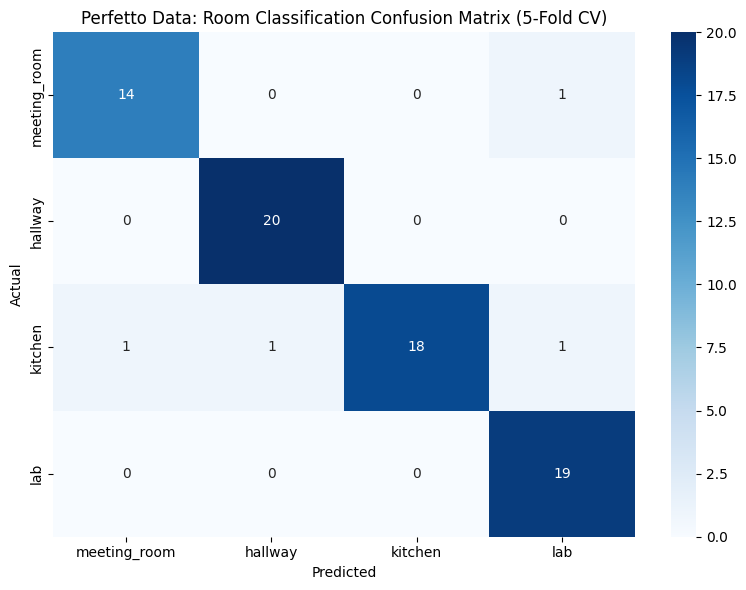


=== FEATURE IMPORTANCE ===
                                 feature  importance
0               gpu_util_diff_first_last    0.154968
6                         gpu_util_first    0.154547
1               Avg Preemption Delay_std    0.126698
5               Avg Preemption Delay_p90    0.109913
8                         gpu_util_range    0.093382
7                            gpu_util_cv    0.091001
3               Avg Preemption Delay_p75    0.088226
4                           gpu_util_std    0.082696
2                           gpu_util_iqr    0.057812
11            display_refresh_rate_first    0.021938
9       display_refresh_rate_num_changes    0.010579
10  display_refresh_rate_diff_first_last    0.008239


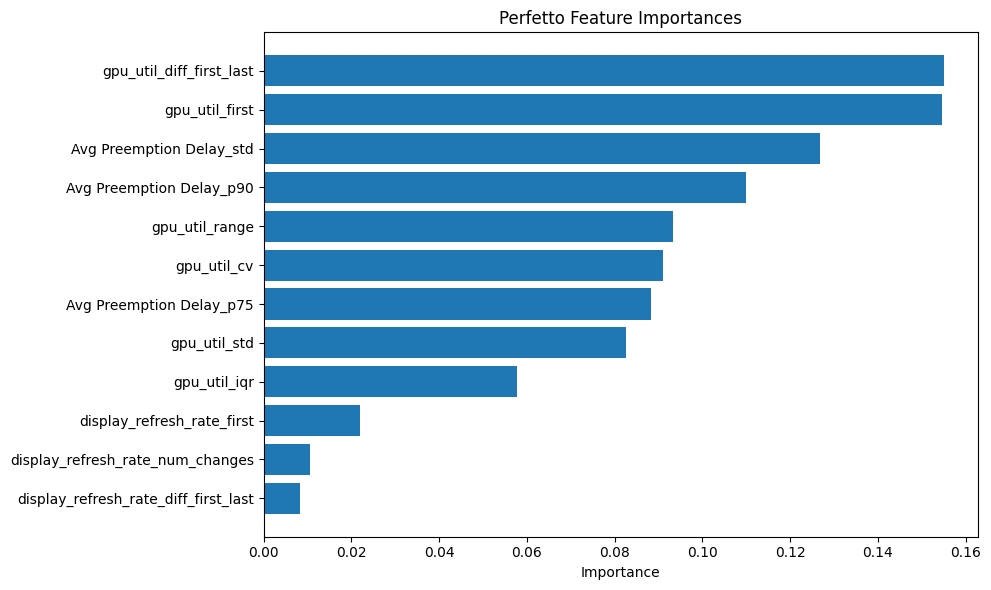

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = perfetto_df_extended.drop(columns=['room', 'filename'])
y = perfetto_df_extended['room']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

cv_scores = cross_val_score(rf_model, X_scaled, y, cv=kfold, scoring='accuracy')

print("=== PERFETTO MODEL: 5-FOLD CROSS-VALIDATION ===")
print(f"Fold accuracies: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Std deviation: {cv_scores.std():.4f}")
print(f"95% CI: {cv_scores.mean():.4f} ± {1.96 * cv_scores.std():.4f}")

# Get predictions for all samples
y_pred_cv = cross_val_predict(rf_model, X_scaled, y, cv=kfold)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y, y_pred_cv))

# Confusion Matrix
cm = confusion_matrix(y, y_pred_cv, labels=['blinds', 'hallway', 'kitchen', 'lab'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['meeting_room', 'hallway', 'kitchen', 'lab'],
            yticklabels=['meeting_room', 'hallway', 'kitchen', 'lab'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Perfetto Data: Room Classification Confusion Matrix')
plt.tight_layout()
plt.savefig('perfetto_confusion_matrix.png')
plt.show()

# Feature importance
rf_model.fit(X_scaled, y)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Perfetto Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('perfetto_feature_importance.png')
plt.show()

=== BOOTSTRAPPING PERFETTO MODEL (1000 iterations) ===

Iterations completed: 1000
Mean accuracy: 0.9373
Std deviation: 0.0455
95% CI: [0.8276, 1.0000]
Min accuracy: 0.6667
Max accuracy: 1.0000


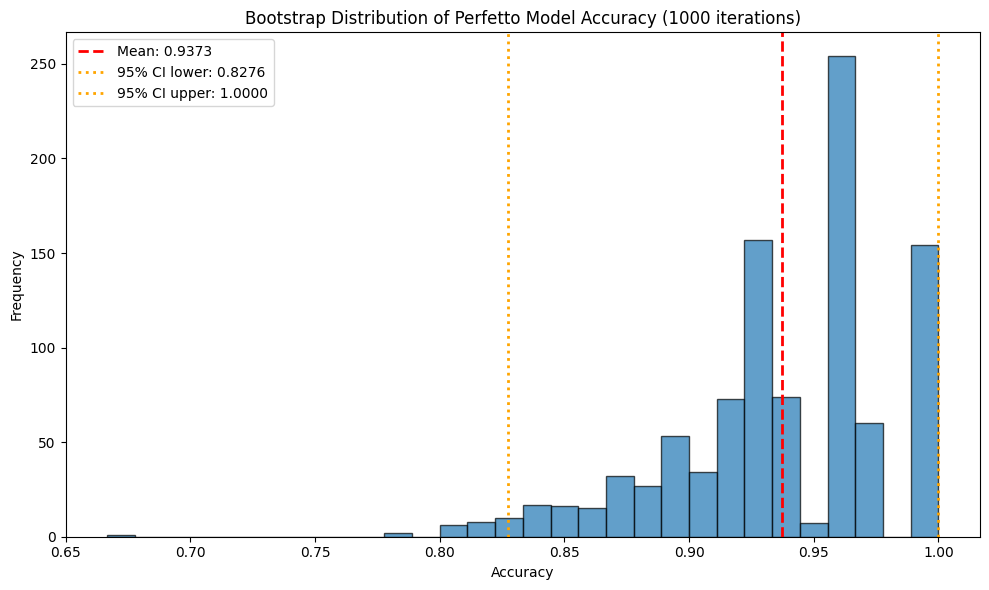

In [16]:
from sklearn.utils import resample
import numpy as np

# Prepare data
X = perfetto_df_extended.drop(columns=['room', 'filename'])
y = perfetto_df_extended['room']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bootstrap
n_iterations = 1000
bootstrap_accuracies = []

print("=== BOOTSTRAPPING PERFETTO MODEL (1000 iterations) ===\n")

for i in range(n_iterations):
    # Sample with replacement for training
    indices = resample(range(len(X_scaled)), random_state=i)
    oob_indices = list(set(range(len(X_scaled))) - set(indices))  # Out-of-bag samples
    
    if len(oob_indices) < 5:  # Skip if too few OOB samples
        continue
    
    X_train = X_scaled[indices]
    y_train = y.iloc[indices]
    X_test = X_scaled[oob_indices]
    y_test = y.iloc[oob_indices]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    acc = rf.score(X_test, y_test)
    bootstrap_accuracies.append(acc)

print(f"Iterations completed: {len(bootstrap_accuracies)}")
print(f"Mean accuracy: {np.mean(bootstrap_accuracies):.4f}")
print(f"Std deviation: {np.std(bootstrap_accuracies):.4f}")
print(f"95% CI: [{np.percentile(bootstrap_accuracies, 2.5):.4f}, {np.percentile(bootstrap_accuracies, 97.5):.4f}]")
print(f"Min accuracy: {np.min(bootstrap_accuracies):.4f}")
print(f"Max accuracy: {np.max(bootstrap_accuracies):.4f}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(bootstrap_accuracies), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(bootstrap_accuracies):.4f}')
plt.axvline(np.percentile(bootstrap_accuracies, 2.5), color='orange', linestyle=':', linewidth=2, 
            label=f'95% CI lower: {np.percentile(bootstrap_accuracies, 2.5):.4f}')
plt.axvline(np.percentile(bootstrap_accuracies, 97.5), color='orange', linestyle=':', linewidth=2, 
            label=f'95% CI upper: {np.percentile(bootstrap_accuracies, 97.5):.4f}')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Perfetto Model Accuracy (1000 iterations)')
plt.legend()
plt.tight_layout()
plt.savefig('perfetto_bootstrap_accuracy.png')
plt.show()

In [17]:
# Use top 30 features instead of just the optimal 12
TOP_30_FEATURES = results_extended_df.head(30)['feature'].tolist()

print(f"Using {len(TOP_30_FEATURES)} features:")
for f in TOP_30_FEATURES:
    print(f"  {f}")

# Build dataset with more features
perfetto_data_30 = []

for (room, filename), features in aggregated_scans_extended.items():
    row = {
        'room': room,
        'filename': filename,
    }
    
    for feat in TOP_30_FEATURES:
        row[feat] = features.get(feat, 0)
    
    perfetto_data_30.append(row)

perfetto_df_30 = pd.DataFrame(perfetto_data_30).fillna(0)

# Train and evaluate
X_30 = perfetto_df_30.drop(columns=['room', 'filename'])
y_30 = perfetto_df_30['room']

scaler = StandardScaler()
X_30_scaled = scaler.fit_transform(X_30)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

cv_scores = cross_val_score(rf_model, X_30_scaled, y_30, cv=kfold, scoring='accuracy')
print(f"\n=== TOP 30 FEATURES: 5-Fold CV ===")
print(f"Mean accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Using 30 features:
  gpu_util_diff_first_last
  Avg Preemption Delay_std
  gpu_util_iqr
  Avg Preemption Delay_p75
  gpu_util_std
  Avg Preemption Delay_p90
  gpu_util_first
  Avg Preemption Delay_iqr
  Avg Preemption Delay_max
  Avg Preemption Delay_range
  gpu_util_cv
  gpu_util_range
  app_vss_mb_median
  Avg Preemption Delay_last
  app_rss_mb_median
  display_refresh_rate_num_changes
  display_refresh_rate_diff_first_last
  display_refresh_rate_first
  Avg Preemption Delay_mean
  gpu_util_last
  gpu_util_max
  app_vss_mb_p25
  app_rss_mb_p25
  app_vss_mb_mean
  application_layer_count_p75
  application_layer_count_iqr
  gpu_util_p90
  application_layer_count_mean
  gpu_util_min
  app_uss_mb_median

=== TOP 30 FEATURES: 5-Fold CV ===
Mean accuracy: 0.9600 ± 0.0327


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Prepare different feature sets
X_12 = perfetto_df_extended.drop(columns=['room', 'filename']).fillna(0)
X_30 = perfetto_df_30.drop(columns=['room', 'filename']).fillna(0)
y = perfetto_df_extended['room']

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for feature_set_name, X_raw in [('12 features', X_12), ('30 features', X_30)]:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    
    for model_name, model in [
        ('Random Forest (100)', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('Random Forest (200)', RandomForestClassifier(n_estimators=200, random_state=42)),
        ('Random Forest (300)', RandomForestClassifier(n_estimators=300, random_state=42)),
        ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('SVM (C=1)', SVC(kernel='rbf', C=1, random_state=42)),
        ('SVM (C=10)', SVC(kernel='rbf', C=10, random_state=42)),
        ('KNN (k=3)', KNeighborsClassifier(n_neighbors=3)),
        ('KNN (k=5)', KNeighborsClassifier(n_neighbors=5)),
    ]:
        scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='accuracy')
        results.append({
            'Features': feature_set_name,
            'Model': model_name,
            'Mean Accuracy': round(scores.mean(), 4),
            'Std': round(scores.std(), 4),
        })

results_df = pd.DataFrame(results).sort_values('Mean Accuracy', ascending=False)
print("=== COMPREHENSIVE MODEL COMPARISON ===\n")
print(results_df.to_string(index=False))

# Get best model
best = results_df.iloc[0]
print(f"\n=== BEST MODEL ===")
print(f"{best['Model']} with {best['Features']}: {best['Mean Accuracy']:.4f} ± {best['Std']:.4f}")

=== COMPREHENSIVE MODEL COMPARISON ===

   Features               Model  Mean Accuracy    Std
30 features Random Forest (300)         0.9867 0.0267
30 features Random Forest (200)         0.9867 0.0267
30 features           KNN (k=3)         0.9733 0.0533
12 features Random Forest (200)         0.9600 0.0533
30 features Random Forest (100)         0.9600 0.0327
12 features Random Forest (300)         0.9600 0.0533
12 features           KNN (k=3)         0.9600 0.0533
12 features          SVM (C=10)         0.9600 0.0533
30 features           SVM (C=1)         0.9600 0.0533
30 features          SVM (C=10)         0.9467 0.0499
12 features Random Forest (100)         0.9467 0.0653
12 features           SVM (C=1)         0.9333 0.0422
30 features   Gradient Boosting         0.9333 0.0422
12 features           KNN (k=5)         0.9333 0.0422
30 features           KNN (k=5)         0.9333 0.0422
12 features   Gradient Boosting         0.9067 0.0680

=== BEST MODEL ===
Random Forest (300) wi

=== CLASSIFICATION REPORT: RF(300) + 30 Features ===

              precision    recall  f1-score   support

      blinds       1.00      1.00      1.00        15
     hallway       1.00      1.00      1.00        20
     kitchen       1.00      0.95      0.98        21
         lab       0.95      1.00      0.97        19

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



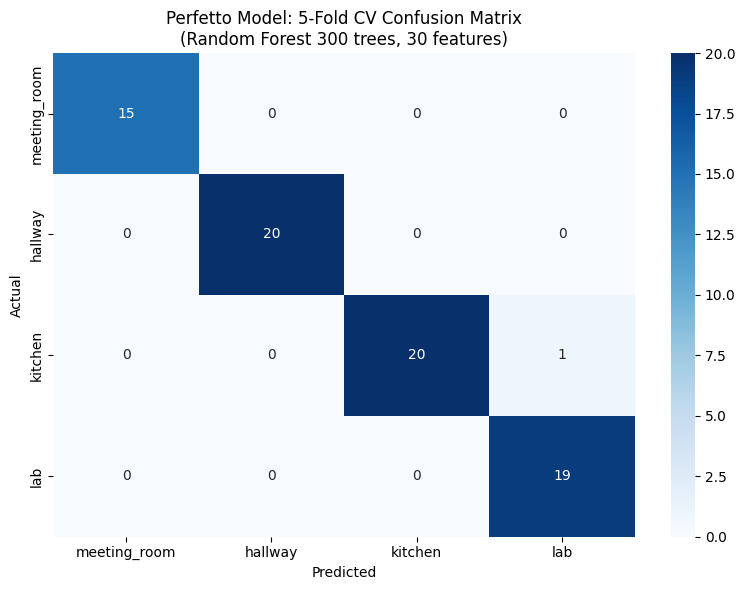


=== MISCLASSIFIED SAMPLES (1) ===
      room               filename
5  kitchen  kitchen_6_cleaned.csv


In [19]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Best model: Random Forest (300) with 30 features
X_best = perfetto_df_30.drop(columns=['room', 'filename']).fillna(0)
y = perfetto_df_30['room']

scaler = StandardScaler()
X_best_scaled = scaler.fit_transform(X_best)

# 5-Fold CV predictions
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

y_pred_cv = cross_val_predict(model, X_best_scaled, y, cv=kfold)

print("=== CLASSIFICATION REPORT: RF(300) + 30 Features ===\n")
print(classification_report(y, y_pred_cv))

# Confusion Matrix
cm = confusion_matrix(y, y_pred_cv, labels=['blinds', 'hallway', 'kitchen', 'lab'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['meeting_room', 'hallway', 'kitchen', 'lab'],
            yticklabels=['meeting_room', 'hallway', 'kitchen', 'lab'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Perfetto Model: 5-Fold CV Confusion Matrix\n(Random Forest 300 trees, 30 features)')
plt.tight_layout()
plt.savefig('perfetto_best_model_confusion_matrix.png')
plt.show()

# Show which samples were misclassified
misclassified = perfetto_df_30[y != y_pred_cv][['room', 'filename']]
print(f"\n=== MISCLASSIFIED SAMPLES ({len(misclassified)}) ===")
print(misclassified)

=== BOOTSTRAPPING BEST MODEL (1000 iterations) ===

Iterations completed: 1000
Mean accuracy: 0.9694
Std deviation: 0.0353
95% CI: [0.8845, 1.0000]
Min accuracy: 0.7391
Max accuracy: 1.0000


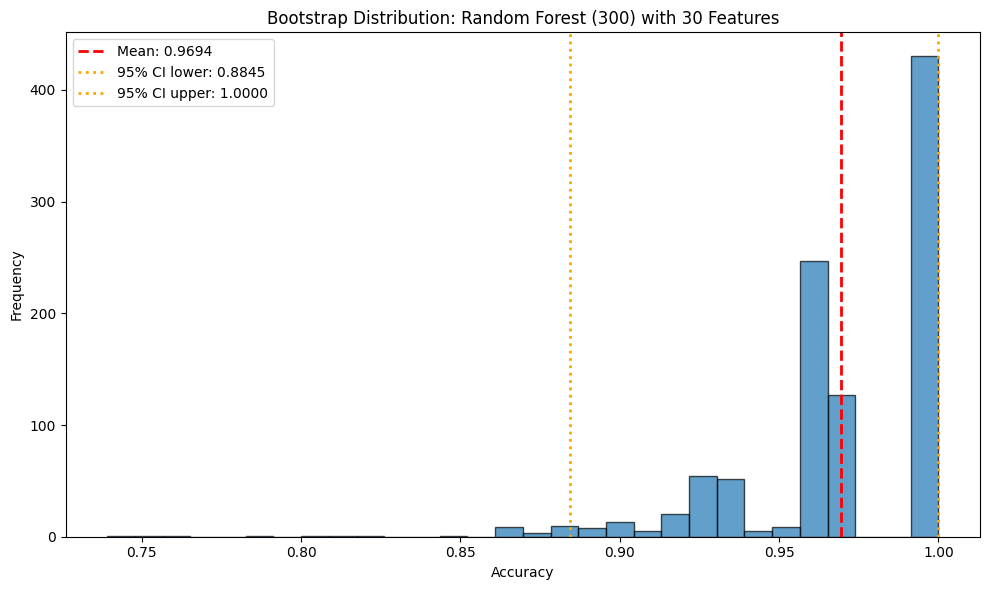

In [20]:
from sklearn.utils import resample
import numpy as np

# Best model: Random Forest (300) with 30 features
X_best = perfetto_df_30.drop(columns=['room', 'filename']).fillna(0)
y = perfetto_df_30['room']

scaler = StandardScaler()
X_best_scaled = scaler.fit_transform(X_best)

n_iterations = 1000
bootstrap_accuracies = []

print("=== BOOTSTRAPPING BEST MODEL (1000 iterations) ===\n")

for i in range(n_iterations):
    indices = resample(range(len(X_best_scaled)), random_state=i)
    oob_indices = list(set(range(len(X_best_scaled))) - set(indices))
    
    if len(oob_indices) < 5:
        continue
    
    X_train = X_best_scaled[indices]
    y_train = y.iloc[indices]
    X_test = X_best_scaled[oob_indices]
    y_test = y.iloc[oob_indices]
    
    model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    bootstrap_accuracies.append(acc)

print(f"Iterations completed: {len(bootstrap_accuracies)}")
print(f"Mean accuracy: {np.mean(bootstrap_accuracies):.4f}")
print(f"Std deviation: {np.std(bootstrap_accuracies):.4f}")
print(f"95% CI: [{np.percentile(bootstrap_accuracies, 2.5):.4f}, {np.percentile(bootstrap_accuracies, 97.5):.4f}]")
print(f"Min accuracy: {np.min(bootstrap_accuracies):.4f}")
print(f"Max accuracy: {np.max(bootstrap_accuracies):.4f}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(bootstrap_accuracies), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(bootstrap_accuracies):.4f}')
plt.axvline(np.percentile(bootstrap_accuracies, 2.5), color='orange', linestyle=':', linewidth=2, 
            label=f'95% CI lower: {np.percentile(bootstrap_accuracies, 2.5):.4f}')
plt.axvline(np.percentile(bootstrap_accuracies, 97.5), color='orange', linestyle=':', linewidth=2, 
            label=f'95% CI upper: {np.percentile(bootstrap_accuracies, 97.5):.4f}')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution: Random Forest (300) with 30 Features')
plt.legend()
plt.tight_layout()
plt.savefig('perfetto_bootstrap_best_model.png')
plt.show()

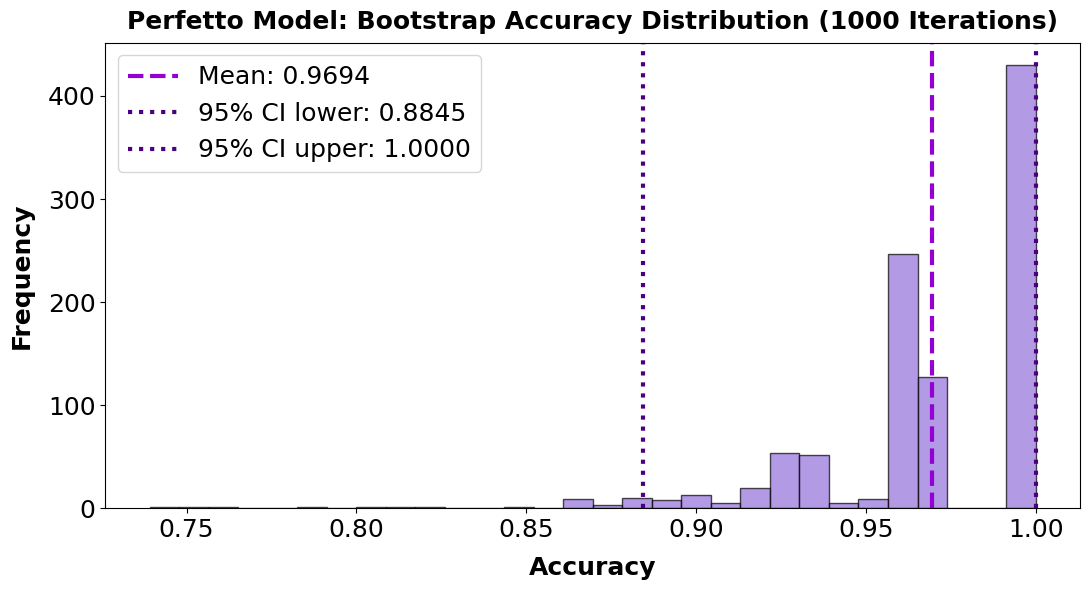

In [50]:
# Re-plot with poster styling - NO NEED TO RE-RUN BOOTSTRAP
plt.figure(figsize=(11, 6))

# Purple histogram
plt.hist(bootstrap_accuracies, bins=30, edgecolor='black', alpha=0.7, color='mediumpurple')

# Dark purple lines
plt.axvline(np.mean(bootstrap_accuracies), color='darkviolet', linestyle='--', linewidth=3, 
            label=f'Mean: {np.mean(bootstrap_accuracies):.4f}')
plt.axvline(np.percentile(bootstrap_accuracies, 2.5), color='indigo', linestyle=':', linewidth=3, 
            label=f'95% CI lower: {np.percentile(bootstrap_accuracies, 2.5):.4f}')
plt.axvline(np.percentile(bootstrap_accuracies, 97.5), color='indigo', linestyle=':', linewidth=3, 
            label=f'95% CI upper: {np.percentile(bootstrap_accuracies, 97.5):.4f}')

# Poster-sized fonts
plt.xlabel('Accuracy', fontsize=18, fontweight='bold', labelpad=10)
plt.ylabel('Frequency', fontsize=18, fontweight='bold', labelpad=10)
plt.title('Perfetto Model: Bootstrap Accuracy Distribution (1000 Iterations)', fontsize=18, fontweight='bold', pad=10)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc='upper left')

plt.tight_layout()
plt.savefig('perfetto_bootstrap_poster.png', dpi=300, bbox_inches='tight')
plt.show()

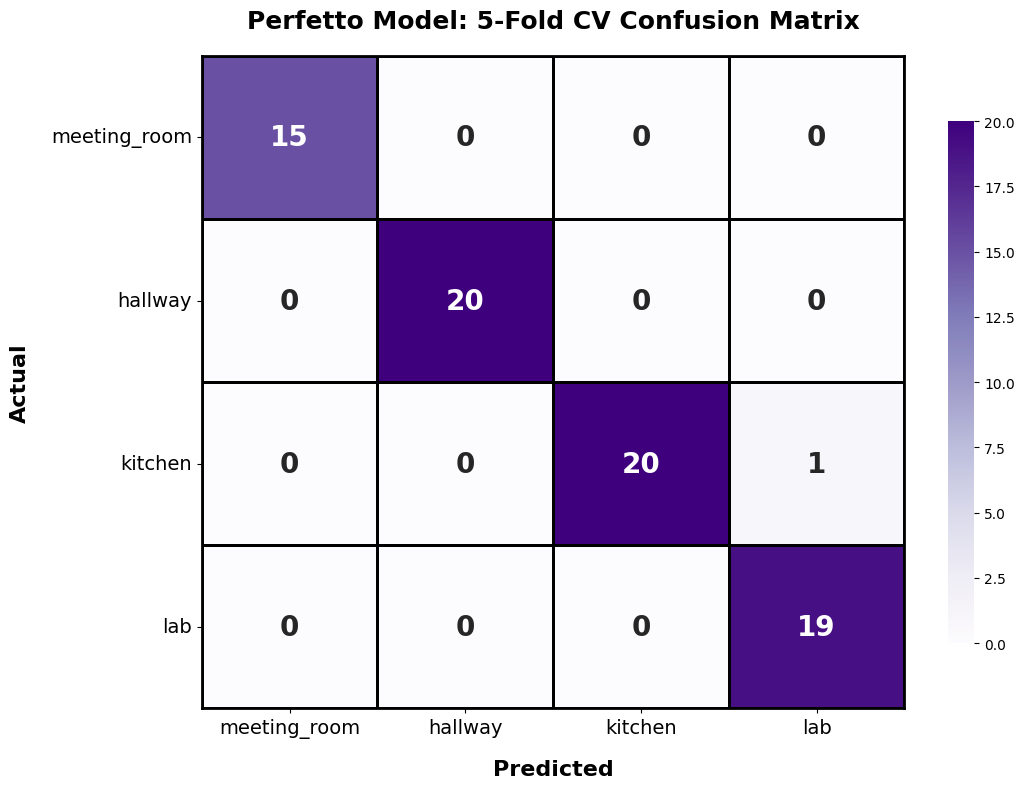

In [42]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Best model: Random Forest (300) with 30 features
X_best = perfetto_df_30.drop(columns=['room', 'filename']).fillna(0)
y = perfetto_df_30['room']

scaler = StandardScaler()
X_best_scaled = scaler.fit_transform(X_best)

# 5-Fold CV predictions
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

y_pred_cv = cross_val_predict(model, X_best_scaled, y, cv=kfold)

# Confusion Matrix - PURPLE POSTER STYLE
# Confusion Matrix - PURPLE POSTER STYLE WITH BLACK OUTLINE
cm = confusion_matrix(y, y_pred_cv, labels=['blinds', 'hallway', 'kitchen', 'lab'])

plt.figure(figsize=(11, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['meeting_room', 'hallway', 'kitchen', 'lab'],
            yticklabels=['meeting_room', 'hallway', 'kitchen', 'lab'],
            annot_kws={'size': 20, 'fontweight': 'bold'},
            cbar_kws={'shrink': 0.8},
            linewidths=2, linecolor='black')  # Black outline between cells

# Add outer border
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(2)

plt.xlabel('Predicted', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Actual', fontsize=16, fontweight='bold', labelpad=15)
plt.title('Perfetto Model: 5-Fold CV Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=0)

plt.tight_layout()
plt.savefig('perfetto_confusion_matrix_poster.png', dpi=300, bbox_inches='tight')
plt.show()

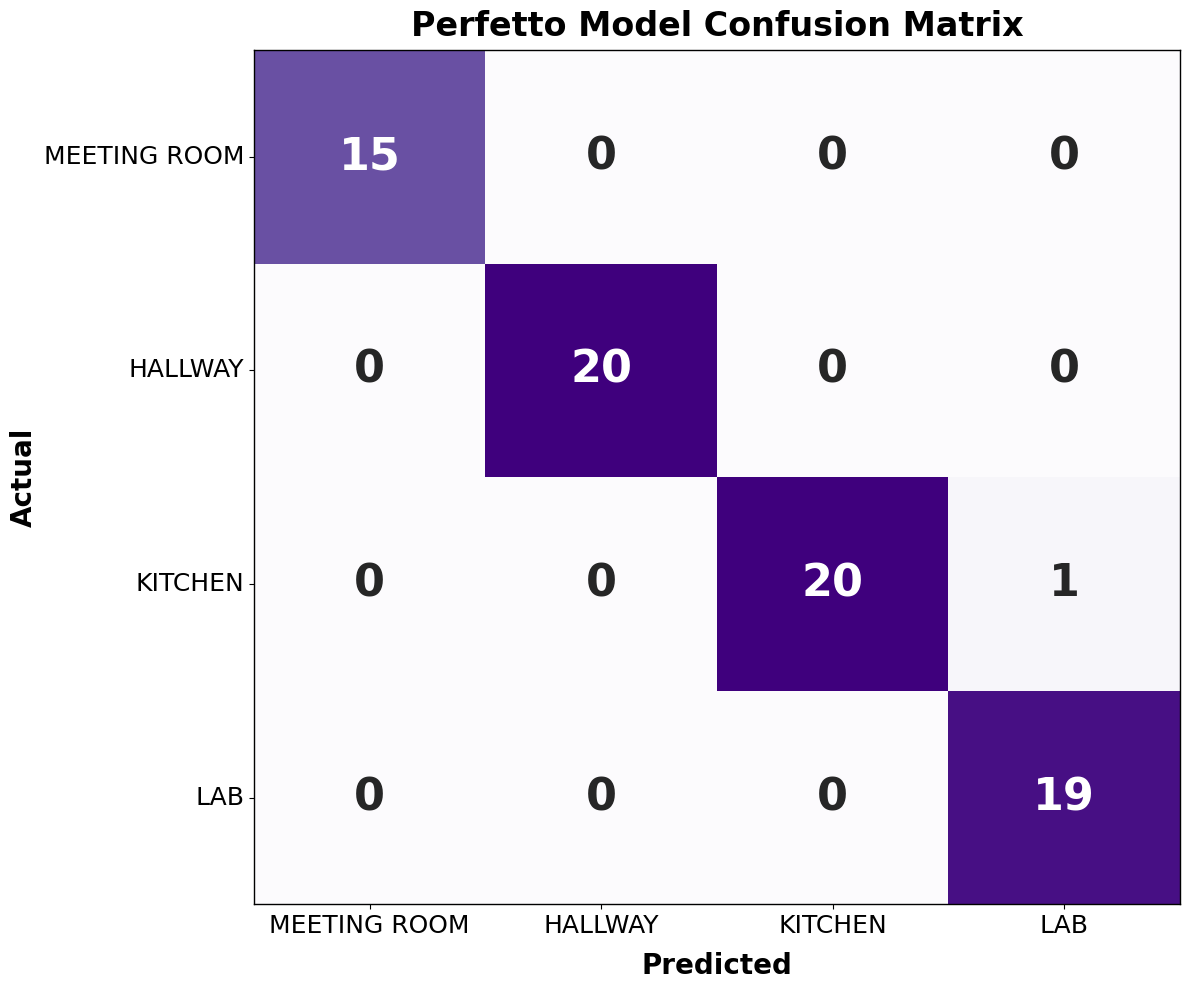

In [47]:
# Confusion Matrix - PURPLE POSTER STYLE WITH BLACK OUTLINE, NO LEGEND
cm = confusion_matrix(y, y_pred_cv, labels=['blinds', 'hallway', 'kitchen', 'lab'])

plt.figure(figsize=(12, 10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['MEETING ROOM', 'HALLWAY', 'KITCHEN', 'LAB'],
            yticklabels=['MEETING ROOM', 'HALLWAY', 'KITCHEN', 'LAB'],
            annot_kws={'size': 32, 'fontweight': 'bold'},
            cbar=False)

# Add outer border
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.xlabel('Predicted', fontsize=20, fontweight='bold', labelpad=10)
plt.ylabel('Actual', fontsize=20, fontweight='bold')
plt.title('Perfetto Model Confusion Matrix', fontsize=24, fontweight='bold', pad=10)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=0)

plt.tight_layout()
plt.savefig('perfetto_confusion_matrix_poster.png', dpi=300, bbox_inches='tight')
plt.show()

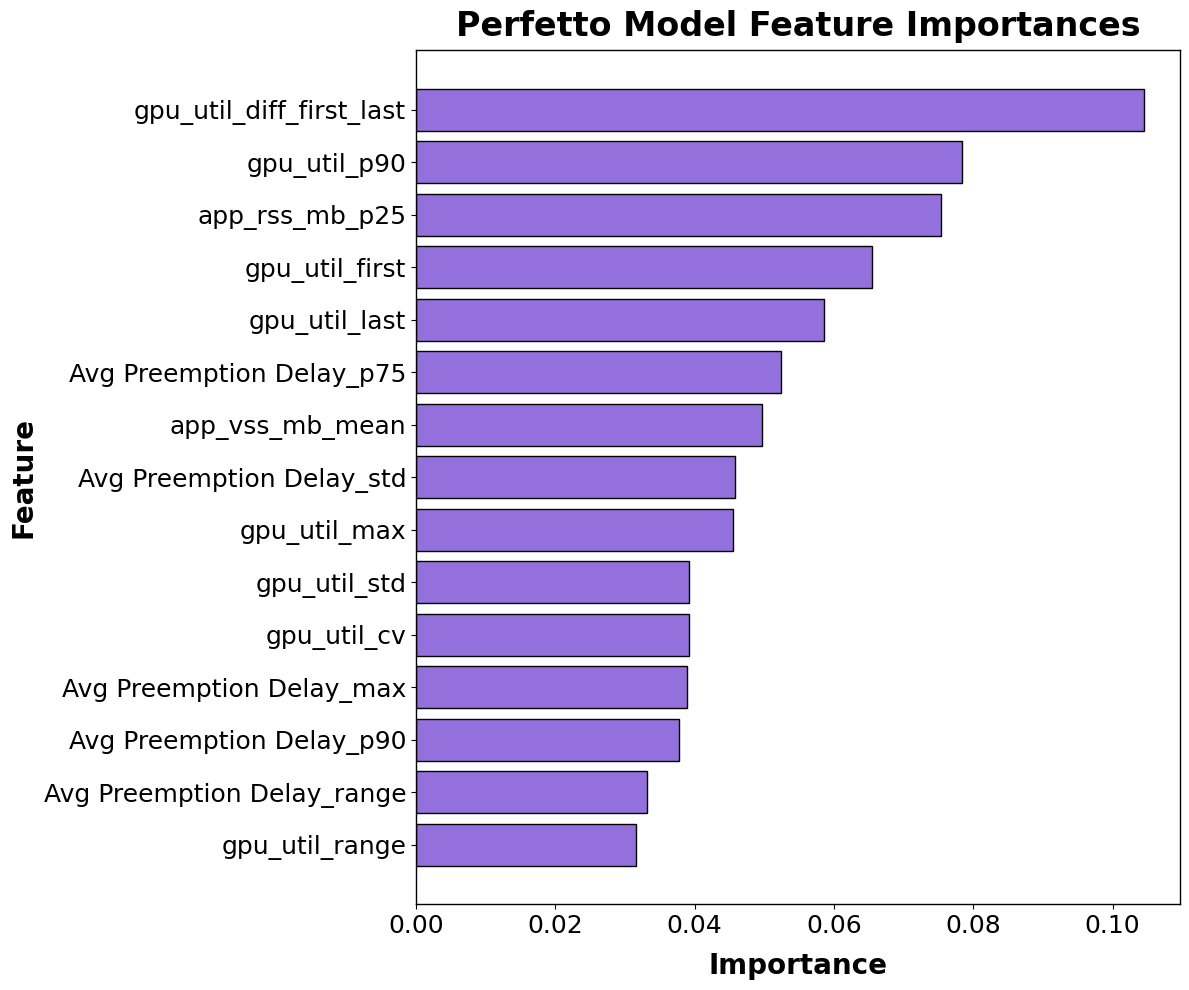

In [48]:
# Train model to get feature importance
model.fit(X_best_scaled, y)

feature_importance = pd.DataFrame({
    'feature': X_best.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features - PURPLE POSTER STYLE
plt.figure(figsize=(12, 10))
top_15 = feature_importance.head(15)

bars = plt.barh(range(len(top_15)), top_15['importance'], color='mediumpurple', edgecolor='black', linewidth=1)
plt.yticks(range(len(top_15)), top_15['feature'], fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('Importance', fontsize=20, fontweight='bold', labelpad=10)
plt.ylabel('Feature', fontsize=20, fontweight='bold')
plt.title('Perfetto Model Feature Importances', fontsize=24, fontweight='bold', pad=10)
plt.gca().invert_yaxis()

# Add outer border
for _, spine in plt.gca().spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tight_layout()
plt.savefig('perfetto_feature_importance_poster.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
# Perfetto Model Metrics Summary
perfetto_cv_accuracy = cv_scores.mean()
perfetto_cv_std = cv_scores.std()
perfetto_bootstrap_mean = np.mean(bootstrap_accuracies)
perfetto_bootstrap_std = np.std(bootstrap_accuracies)
perfetto_bootstrap_ci_lower = np.percentile(bootstrap_accuracies, 2.5)
perfetto_bootstrap_ci_upper = np.percentile(bootstrap_accuracies, 97.5)
perfetto_bootstrap_min = np.min(bootstrap_accuracies)
perfetto_bootstrap_max = np.max(bootstrap_accuracies)

print("=" * 80)
print("PERFETTO MODEL SUMMARY")
print("=" * 80)
print(f"""
PERFETTO MODEL (Random Forest, 300 trees, {X_best.shape[1]} features)

5-FOLD CROSS-VALIDATION
  • Accuracy:               {perfetto_cv_accuracy:.2%} ± {perfetto_cv_std:.2%}

BOOTSTRAP (1000 iterations)
  • Mean Accuracy:          {perfetto_bootstrap_mean:.2%}
  • Std Deviation:          {perfetto_bootstrap_std:.2%}
  • 95% CI:                 [{perfetto_bootstrap_ci_lower:.2%}, {perfetto_bootstrap_ci_upper:.2%}]
  • Min Accuracy:           {perfetto_bootstrap_min:.2%}
  • Max Accuracy:           {perfetto_bootstrap_max:.2%}
  • Range:                  {perfetto_bootstrap_max - perfetto_bootstrap_min:.2%}
""")

PERFETTO MODEL SUMMARY

PERFETTO MODEL (Random Forest, 300 trees, 30 features)

5-FOLD CROSS-VALIDATION
  • Accuracy:               96.00% ± 3.27%

BOOTSTRAP (1000 iterations)
  • Mean Accuracy:          96.94%
  • Std Deviation:          3.53%
  • 95% CI:                 [88.45%, 100.00%]
  • Min Accuracy:           73.91%
  • Max Accuracy:           100.00%
  • Range:                  26.09%



In [52]:
# Make sure you have the fold scores - rerun this if needed (it's fast, not like bootstrap)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(model, X_best_scaled, y, cv=kfold, scoring='accuracy')

# Perfetto Model Metrics Summary
perfetto_cv_accuracy = cv_scores.mean()
perfetto_cv_std = cv_scores.std()
perfetto_bootstrap_mean = np.mean(bootstrap_accuracies)
perfetto_bootstrap_std = np.std(bootstrap_accuracies)
perfetto_bootstrap_ci_lower = np.percentile(bootstrap_accuracies, 2.5)
perfetto_bootstrap_ci_upper = np.percentile(bootstrap_accuracies, 97.5)
perfetto_bootstrap_min = np.min(bootstrap_accuracies)
perfetto_bootstrap_max = np.max(bootstrap_accuracies)

print("=" * 80)
print("PERFETTO MODEL SUMMARY")
print("=" * 80)
print(f"""
PERFETTO MODEL (Random Forest, 300 trees, {X_best.shape[1]} features)

5-FOLD CROSS-VALIDATION
  • Accuracy:               {perfetto_cv_accuracy:.2%} ± {perfetto_cv_std:.2%}
  • Fold Scores:            {cv_scores}

BOOTSTRAP (1000 iterations)
  • Mean Accuracy:          {perfetto_bootstrap_mean:.2%}
  • Std Deviation:          {perfetto_bootstrap_std:.2%}
  • 95% CI:                 [{perfetto_bootstrap_ci_lower:.2%}, {perfetto_bootstrap_ci_upper:.2%}]
  • Min Accuracy:           {perfetto_bootstrap_min:.2%}
  • Max Accuracy:           {perfetto_bootstrap_max:.2%}
  • Range:                  {perfetto_bootstrap_max - perfetto_bootstrap_min:.2%}
""")

PERFETTO MODEL SUMMARY

PERFETTO MODEL (Random Forest, 300 trees, 30 features)

5-FOLD CROSS-VALIDATION
  • Accuracy:               98.67% ± 2.67%
  • Fold Scores:            [1.         0.93333333 1.         1.         1.        ]

BOOTSTRAP (1000 iterations)
  • Mean Accuracy:          96.94%
  • Std Deviation:          3.53%
  • 95% CI:                 [88.45%, 100.00%]
  • Min Accuracy:           73.91%
  • Max Accuracy:           100.00%
  • Range:                  26.09%

